# Predictive Maintenance Workshop

This notebook is an educational walkthrough that uses the feature extraction and pipeline functions in `Preparation/Sample Preparation/Feature_extraction_pipeline` to:

1. Load and inspect audio files
2. Visualize waveforms and spectrograms
3. Extract features (MFCC + simple statistics)
4. Prepare data and train multiple models
5. Compare model performance and run inference on new audio files

Run cells sequentially. If you are missing optional packages (librosa, ipywidgets), install them first.

In [1]:
# Basic imports and configuration
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

sns.set_theme(style="whitegrid")
np.random.seed(42)

# Add local feature-extraction package to path so we can import our functions
sys.path.append(str(Path('./Preparation/Sample Preparation/Feature_extraction_pipeline').resolve()))

# Import the functions implemented in the repository
from loader import load_long_audio
from splitters import segment_train_test
from features_extractor import extract_mfcc_features, extract_features_for_list
from orchestrator import run_pipeline_on_dataset, run_pipeline_on_file
# rich_features is optional and lazily loaded by upstream orchestrator code in the repo

print('Imports OK')

# --- Pipeline parameter cell will be right below; edit it to change behavior for the whole notebook ---


Imports OK


In [2]:
# Populate `df` with audio files found under data/audio and set `data_dir`
data_dir = Path("data/audio")
_allowed_exts = {".wav", ".flac", ".mp3", ".m4a", ".ogg"}

if not data_dir.exists():
    raise SystemExit(f"Data directory not found: {data_dir}. Create it and place audio files under subfolders per-class (e.g. data/audio/<label>/*.wav)")

_records = []
for f in sorted(data_dir.rglob("*")):
    if f.is_file() and f.suffix.lower() in _allowed_exts:
        _records.append({"file_path": f, "label": f.parent.name})

df = pd.DataFrame(_records)

if df.empty:
    raise SystemExit(f"No audio files found under {data_dir}. Use extensions: {_allowed_exts}")

print(f"Found {len(df)} audio files under {data_dir}")
display(df.head())

Found 4 audio files under data/audio


,file_path,label
0,data/audio/Chipped Tooth/20250930_170743.wav,Chipped Tooth
1,data/audio/Chipped Tooth/20250930_171840.wav,Chipped Tooth
2,data/audio/Good/20250930_163202.wav,Good
3,data/audio/Good/20250930_164401.wav,Good


File: data/audio/Good/20250930_163202.wav  Label: Good
Duration: 600.00 s, SR: 40000 Hz


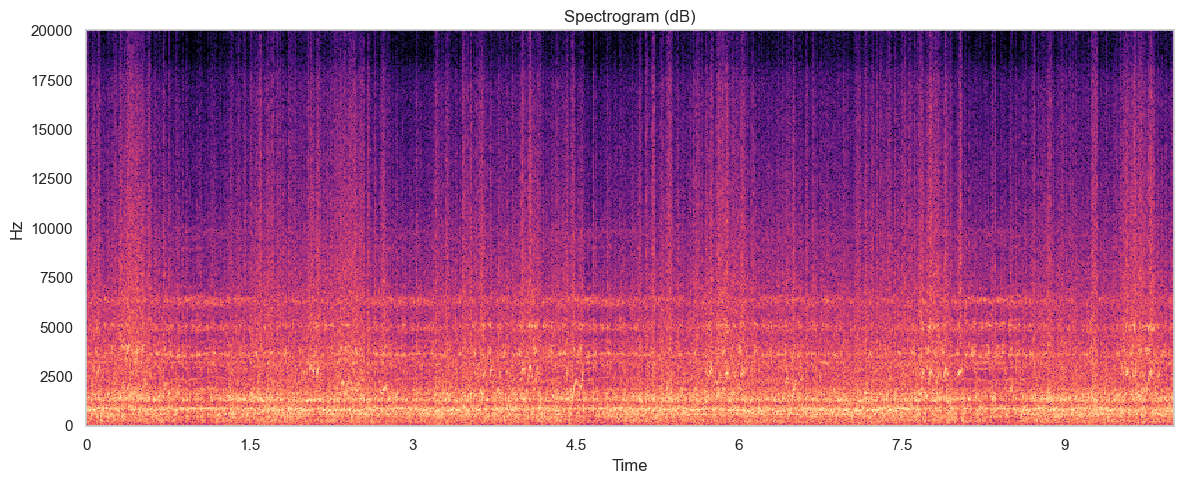

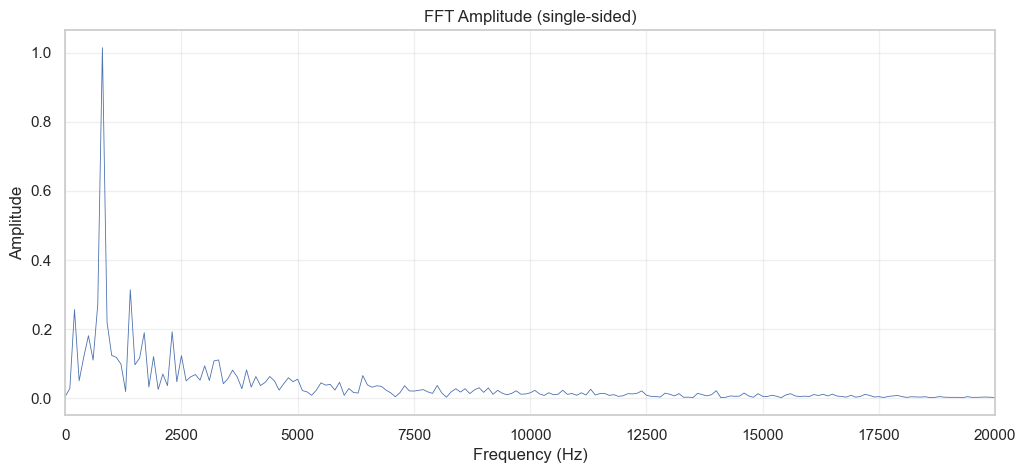

In [3]:
# Pick a sample index (change to explore other files)
if len(df) == 0:
    raise SystemExit('No audio files found in data_dir; please update the path or add samples.')

sample_idx = 2
sample_file = df.iloc[sample_idx]['file_path']
sample_label = df.iloc[sample_idx]['label']

# Load audio using the repo loader (returns mono 1-D numpy array and sr)
audio_data, sr = load_long_audio(sample_file)
print(f'File: {sample_file}  Label: {sample_label}')
print(f'Duration: {len(audio_data)/sr:.2f} s, SR: {sr} Hz')

# Play audio (small files)
#display(Audio(data=audio_data, rate=sr))
audio_data=audio_data[:sr*10]  # limit to first 10 seconds for playback
display(Audio(data=audio_data, rate=sr))
# Plot waveform + spectrogram
import librosa
import librosa.display


# Spectrogram (log amplitude)
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))
S = np.abs(librosa.stft(audio_data, n_fft=1024, hop_length=512))
S_db = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', ax=ax1)
# set title on the Axes object (plt.set_title does not exist)
ax1.set_title('Spectrogram (dB)')
plt.tight_layout()
plt.show()

# Compute single-sided FFT amplitude for the current audio_data (linear amplitude)
N = len(audio_data[:400])
yf = np.fft.rfft(audio_data[:400])
freqs = np.fft.rfftfreq(N, 1.0 / sr)

# Single-sided amplitude scaling
mag = np.abs(yf) / N
if mag.size > 2:
    mag[1:-1] *= 2.0

# Plot amplitude spectrum
plt.figure(figsize=(12, 5))
plt.plot(freqs, mag, linewidth=0.6)
plt.xlim(0, sr / 2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Amplitude (single-sided)')
plt.grid(alpha=0.3)
plt.show()



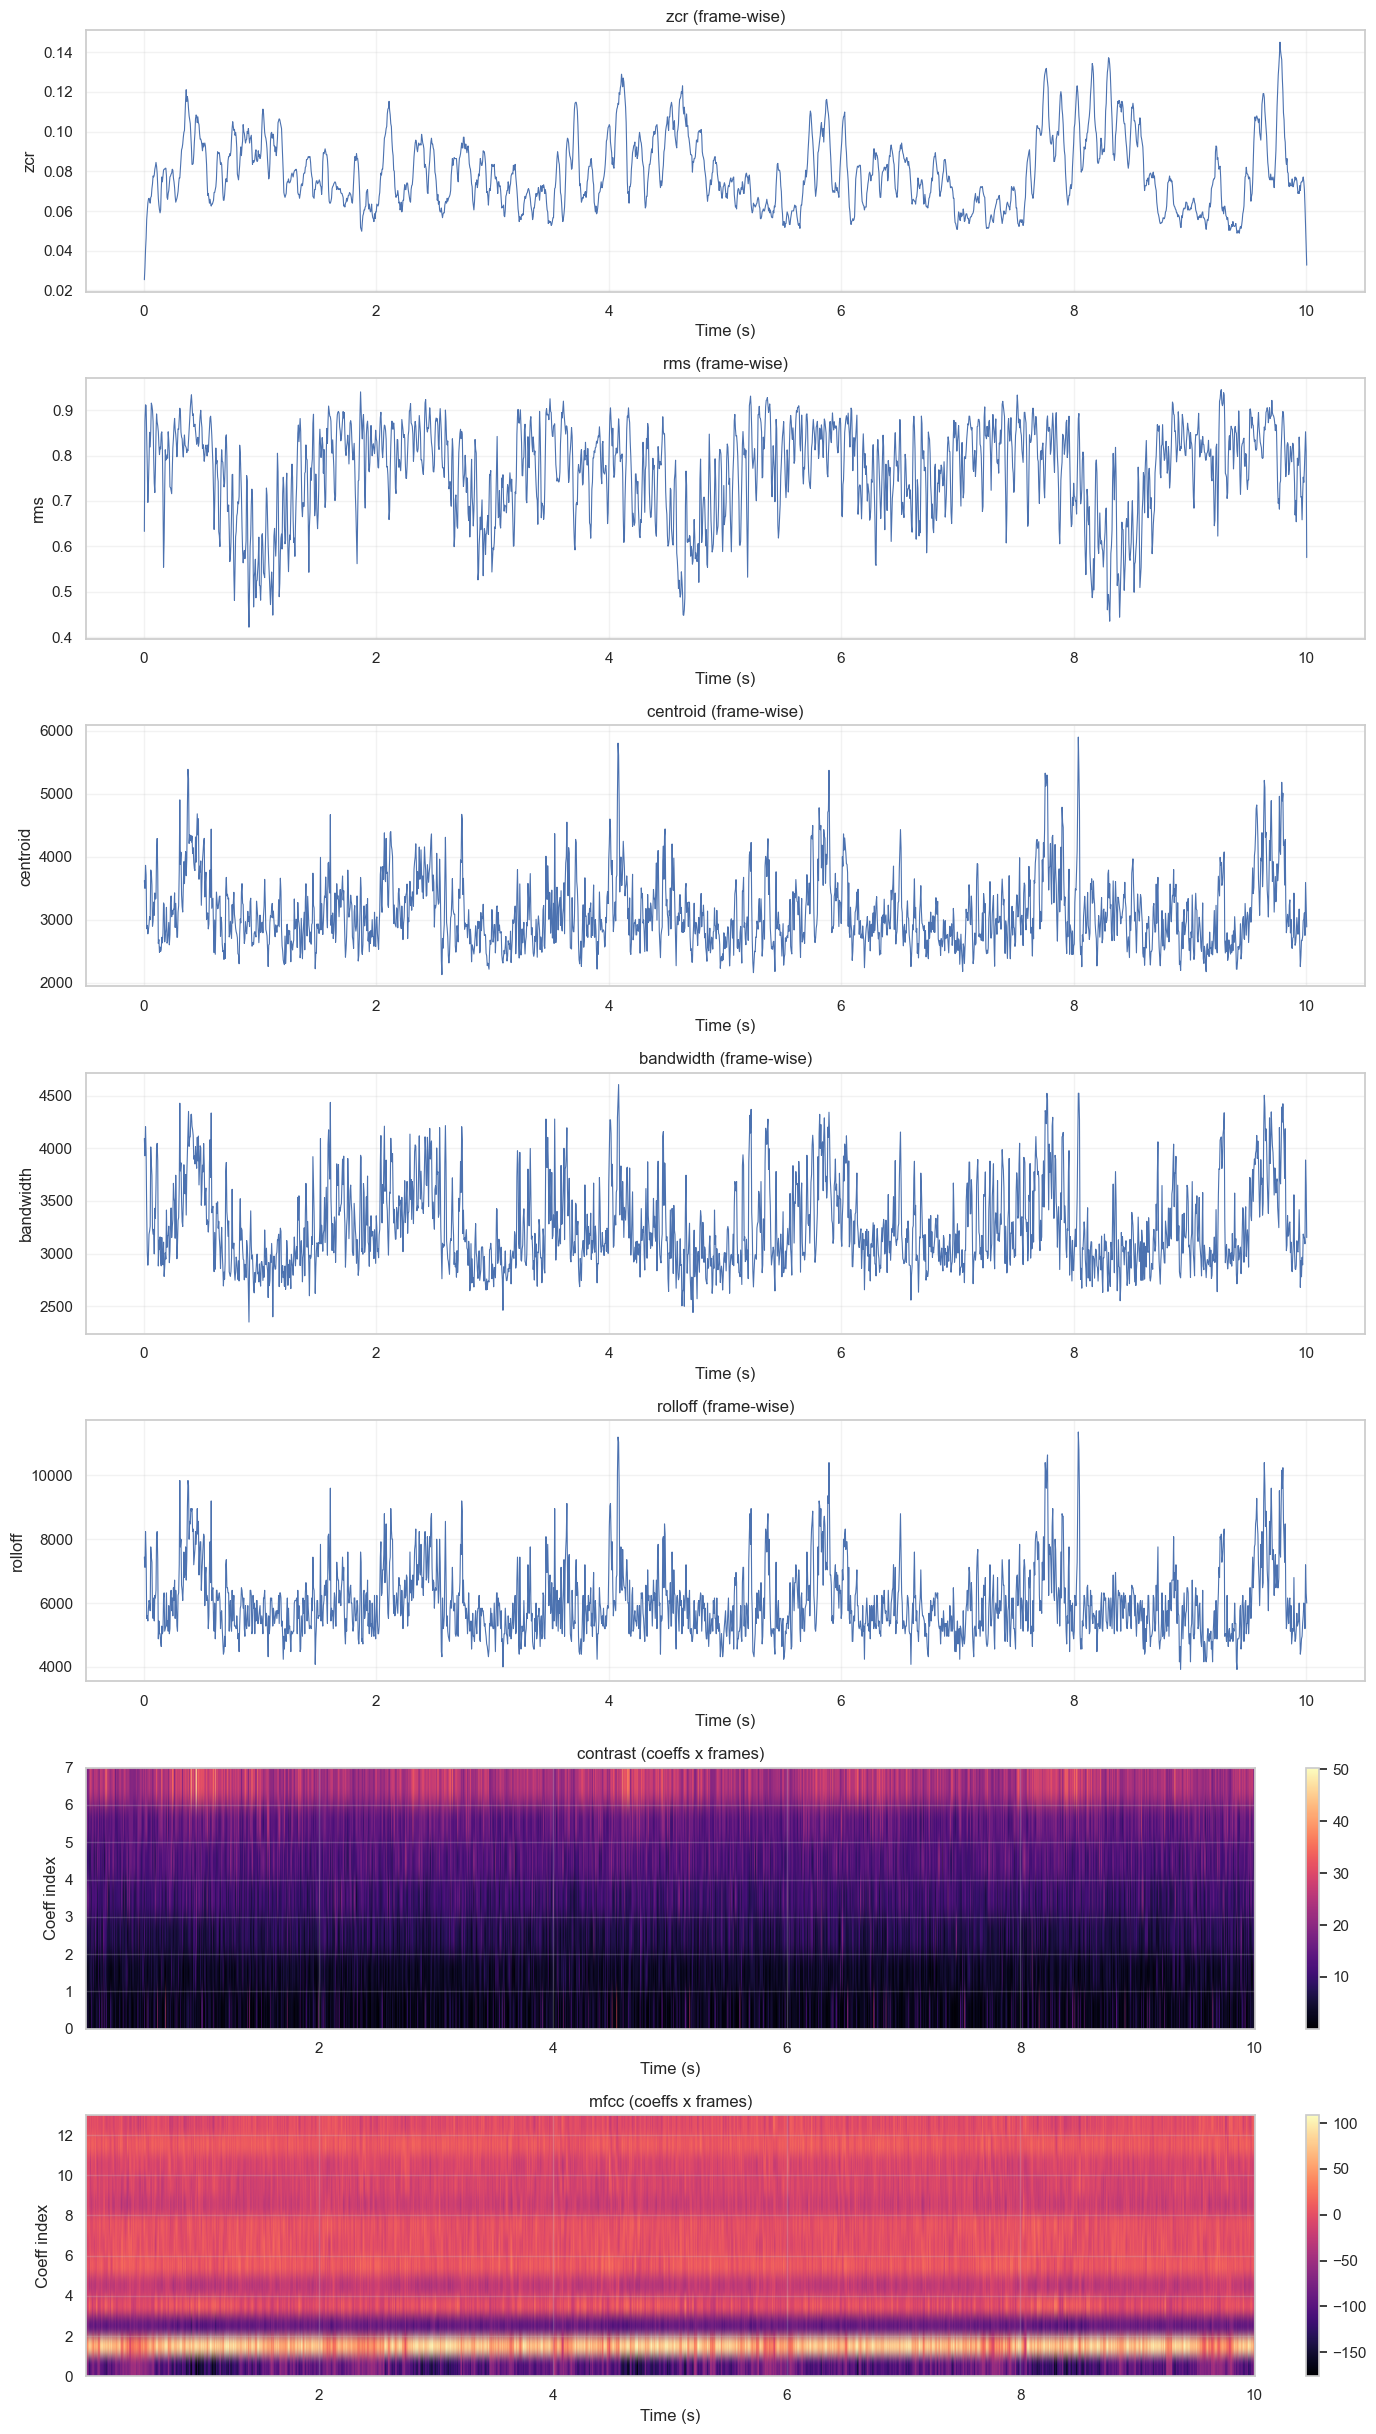

In [4]:
# ---- Representative plots for "rich" features ----
# If a rich_features object exists in the notebook, use it; otherwise compute a set of common features
hop_length = 200
n_fft = 500

if 'rich_features' in globals() and rich_features:
    rf = rich_features
else:
    rf = {}
    y = audio_data
    # common framewise features
    rf['zcr'] = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)[0]
    rf['rms'] = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)[0]
    rf['centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    rf['bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    rf['rolloff'] = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    rf['contrast'] = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    rf['mfcc'] = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# time axis for frame-based features (fallback to STFT frame count)
def frames_time(length):
    if length <= 1:
        return np.array([0.0])
    return librosa.frames_to_time(np.arange(length), sr=sr, hop_length=hop_length, n_fft=n_fft)

# Prepare plotting grid
feat_items = list(rf.items())
n_feats = len(feat_items)
cols = 1
rows = int(np.ceil(n_feats / cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, 3.5 * rows), squeeze=False)
for i, (name, arr) in enumerate(feat_items):
    ax = axes[i // cols][i % cols]
    arr = np.asarray(arr)
    # 1D: simple time series
    if arr.ndim == 1:
        t = frames_time(arr.shape[0])
        ax.plot(t, arr, linewidth=0.8)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel(name)
        ax.set_title(f'{name} (frame-wise)')
    # 2D: show as heatmap (coeffs x frames)
    elif arr.ndim == 2:
        frames = arr.shape[1]
        t = frames_time(frames)
        extent = [t[0], t[-1] if len(t)>0 else 0, 0, arr.shape[0]]
        im = ax.imshow(arr, aspect='auto', origin='lower', extent=extent, cmap='magma')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Coeff index')
        ax.set_title(f'{name} (coeffs x frames)')
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    else:
        ax.text(0.5, 0.5, f'Unsupported shape {arr.shape}', ha='center', va='center')
    ax.grid(alpha=0.25)

# Hide any unused axes
for j in range(n_feats, rows * cols):
    axes[j // cols][j % cols].axis('off')

plt.tight_layout()
plt.show()

## 3) Feature extraction (MFCC demo)

We'll segment the audio into 1-second windows (50% overlap) and compute MFCC means + delta means for each segment using `extract_features_for_list`. This is the lightweight extractor present in the repo.

Produced 14 train-style segments from the sample file
Features shape: (10, 26)


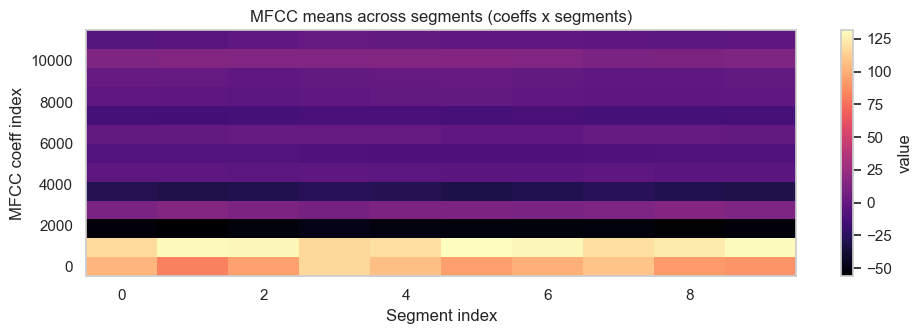

In [5]:
# Segment audio into 1s windows (train-style segmentation)
segments = segment_train_test(audio_data, sr, segment_seconds=1.0, overlap=0.5)
train_segments = segments['train']
print(f'Produced {len(train_segments)} train-style segments from the sample file')

# Extract MFCC-based features for the first few segments
X_sample, feature_names = extract_features_for_list(train_segments[:10], sr)
print('Features shape:', X_sample.shape)

# Improved visualization using librosa (shows MFCC means + delta means)
n_mfcc = X_sample.shape[1] // 2
mfcc_means = X_sample[:, :n_mfcc]
mfcc_deltas = X_sample[:, n_mfcc:]

num = min(3, X_sample.shape[0])

# Heatmap of MFCC means across segments (coeffs x segments)
plt.figure(figsize=(10, 3.5))
librosa.display.specshow(mfcc_means.T, x_axis='frames', y_axis='linear', cmap='magma')
plt.xlabel('Segment index')
plt.ylabel('MFCC coeff index')
plt.title('MFCC means across segments (coeffs x segments)')
plt.colorbar(label='value')
plt.tight_layout()
plt.show()



## 4) Prepare dataset for training

We'll extract features for all files, stack them into X and build y labels. Then we'll split and scale the data.

In [6]:
# Pipeline parameters (edit to change behavior for the whole notebook)
# src_dir: dataset root (expects subfolders per-class)
src_dir = data_dir  # reuse data_dir defined earlier (Path)

# Segmentation / splitting parameters
segment_seconds = 5    # length of segments in seconds
overlap = 0.5            # fraction overlap between segments (0.0 - 1.0)
train_fraction = 0.8     # fraction of data/time used for training per-file splitting
buffer_seconds = 0.0     # seconds to exclude from file boundaries when splitting

# Feature extraction level understood by the orchestrator (common values: 'segment', 'file', etc.)
feature_level = "standard"  #chose from "basic", "standard", "advanced"

print("Pipeline parameters set:",
    dict(src_dir=src_dir, segment_seconds=segment_seconds, overlap=overlap,
         train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level))

Pipeline parameters set: {'src_dir': PosixPath('data/audio'), 'segment_seconds': 5, 'overlap': 0.5, 'train_fraction': 0.8, 'buffer_seconds': 0.0, 'feature_level': 'standard'}


In [7]:
# Use run_pipeline_on_dataset to extract features per file and respect the orchestrator's train/test splitting

def build_dataset_with_orchestrator(src_dir: Path, segment_seconds=segment_seconds, overlap=overlap, train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level):
    """Run the orchestrator over the dataset directory and return stacked train/test datasets.

    Defaults reference the top-level variables so changing them above changes the whole notebook.
    """
    result = run_pipeline_on_dataset(src_dir, segment_seconds=segment_seconds, overlap=overlap, train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level)
    X_train = result['train']['X']
    y_train = np.array(result['train']['y'])
    X_test = result['test']['X']
    y_test = np.array(result['test']['y'])
    return X_train, y_train, X_test, y_test, result

# Run orchestrator on the dataset directory (this will segment per-file and extract richer features when available)
print('Running pipeline on dataset with parameters:', dict(segment_seconds=segment_seconds, overlap=overlap, train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level))
X_train, y_train, X_test, y_test, pipeline_result = build_dataset_with_orchestrator(data_dir)
print('Train X shape:', X_train.shape, 'Test X shape:', X_test.shape)

# Keep the feature names if provided
feat_names = pipeline_result['train'].get('feature_names')
if feat_names:
    print('Feature names available, count =', len(feat_names))
else:
    print('Feature names not available from extractor; using positional indices')


Running pipeline on dataset with parameters: {'segment_seconds': 5, 'overlap': 0.5, 'train_fraction': 0.8, 'buffer_seconds': 0.0, 'feature_level': 'standard'}
Train X shape: (572, 443) Test X shape: (72, 443)
Feature names available, count = 443
Train X shape: (572, 443) Test X shape: (72, 443)
Feature names available, count = 443


In [8]:
# No manual train/test split here — the orchestrator already produced time-contiguous splits per file
from sklearn.preprocessing import StandardScaler

if X_train.size == 0 and X_test.size == 0:
    raise SystemExit('No features extracted — check the dataset and feature extractor')

scaler = StandardScaler()
if X_train.size:
    X_train_scaled = scaler.fit_transform(X_train)
else:
    X_train_scaled = X_train
if X_test.size:
    X_test_scaled = scaler.transform(X_test)
else:
    X_test_scaled = X_test

print('Train shape:', X_train_scaled.shape, 'Test shape:', X_test_scaled.shape)


Train shape: (572, 443) Test shape: (72, 443)


## 5) Train models and evaluate

We'll train three models: RandomForest, SVM, and a small MLP. For speed in a teaching environment, defaults are modest.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# CV parameters
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# models to evaluate (quiet RF during CV)
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, verbose=0),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv):
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f'  CV acc: mean={cv_scores.mean():.4f} std={cv_scores.std():.4f}  (n_splits={n_splits})')
    model.fit(X_train, y_train)
    try:
        y_pred = model.predict(X_test)
    except Exception as e:
        print(f"Warning: could not predict with {name}: {e}")
        acc = float('nan')
        report = ''
        conf = None
    else:
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf = confusion_matrix(y_test, y_pred)
        print(f'  Test acc: {acc:.4f}')
    return {
        'cv_scores': cv_scores,
        'model': model,
        'accuracy': acc,
        'report': report,
        'confusion': conf
    }

# Evaluate models (no explicit for-loop for the evaluation body)
results = {}
results['Random Forest'] = evaluate_model('Random Forest', models['Random Forest'], X_train_scaled, y_train, X_test_scaled, y_test, cv)
results['SVM'] = evaluate_model('SVM', models['SVM'], X_train_scaled, y_train, X_test_scaled, y_test, cv)
results['MLP'] = evaluate_model('MLP', models['MLP'], X_train_scaled, y_train, X_test_scaled, y_test, cv)

# Summary
print('\nSummary (CV mean acc  |  Test acc):')
for name, r in results.items():
    cv_mean = float(np.mean(r['cv_scores'])) if 'cv_scores' in r else np.nan
    print(f"{name:15s} -> CV: {cv_mean:.4f}  |  Test: {r['accuracy']:.4f}")

  CV acc: mean=1.0000 std=0.0000  (n_splits=5)
  Test acc: 1.0000
  CV acc: mean=1.0000 std=0.0000  (n_splits=5)
  Test acc: 1.0000

Summary (CV mean acc  |  Test acc):
SVM             -> CV: 1.0000  |  Test: 1.0000
MLP             -> CV: 1.0000  |  Test: 1.0000
  CV acc: mean=1.0000 std=0.0000  (n_splits=5)
  Test acc: 1.0000

Summary (CV mean acc  |  Test acc):
SVM             -> CV: 1.0000  |  Test: 1.0000
MLP             -> CV: 1.0000  |  Test: 1.0000


In [55]:
# select the trained model with highest recorded accuracy in `results`
best_name, best_info = max(results.items(), key=lambda kv: kv[1]['accuracy'])
best_model = best_info['model']
acc = float(best_info.get('accuracy', np.nan))

# update y_pred_best using the selected model (uses X_test_scaled from notebook)
try:
    y_pred_best = best_model.predict(X_test_scaled)
except Exception as e:
    # if prediction fails, keep previous y_pred_best if present and warn
    print(f"Warning: could not predict with selected model {best_name}: {e}")
else:
    print(f"Selected best model: {best_name} (accuracy={acc:.4f})")

Selected best model: SVM (accuracy=1.0000)


PermutationExplainer explainer: 6it [00:14,  7.28s/it]               



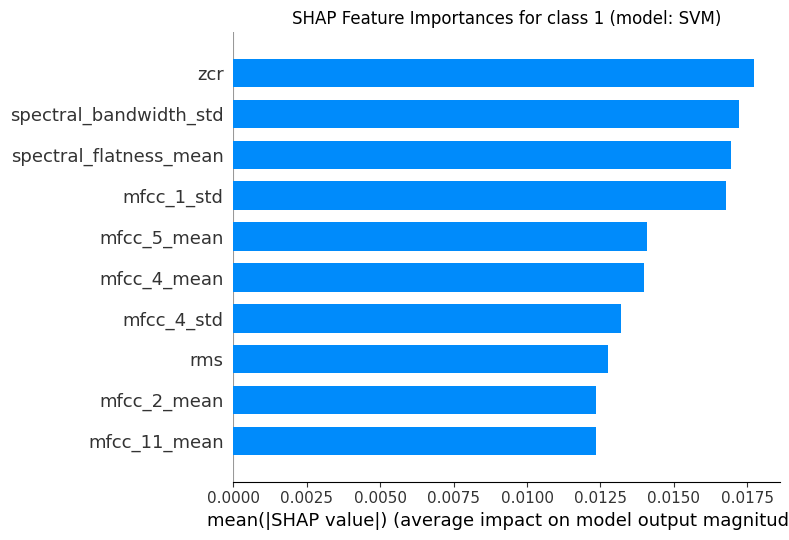

In [56]:
fnames = list(feat_names)

import shap
# background: prefer a small subset of train for explainer speed (use shap.sample for a representative subset)
if 'X_train_scaled' in globals() and getattr(X_train_scaled, "shape", (0,))[0] > 0:
    src_bg = X_train_scaled
else:
    src_bg = X_test_scaled

n_bg = min(10, src_bg.shape[0])
# shap.sample returns a representative subset; fallback to basic indexing if it fails
background = shap.sample(src_bg, n_bg)
explainer = shap.Explainer(best_model.predict_proba, background)
shap_values = explainer.shap_values(X_test_scaled[:5])  # can be slow for some explainers

# Ensure we use matching sample counts: pick the class index and slice data accordingly
sv = shap_values.values if hasattr(shap_values, "values") else shap_values

if sv.ndim == 3:
    # sv shape is (n_samples, n_features, n_classes)
    class_idx = 1
    sv_class = sv[:, :, class_idx]
elif sv.ndim == 2:
    sv_class = sv
else:
    raise AssertionError(f"Unexpected shap_values ndim={sv.ndim}")

n_samples = sv_class.shape[0]
data_for_plot = X_test_scaled[:n_samples]

shap.summary_plot(sv_class, data_for_plot, feature_names=fnames, plot_type='bar', show=False, max_display=10)
plt.title(f'SHAP Feature Importances for class {class_idx} (model: {best_name})')
plt.tight_layout()
plt.show()  

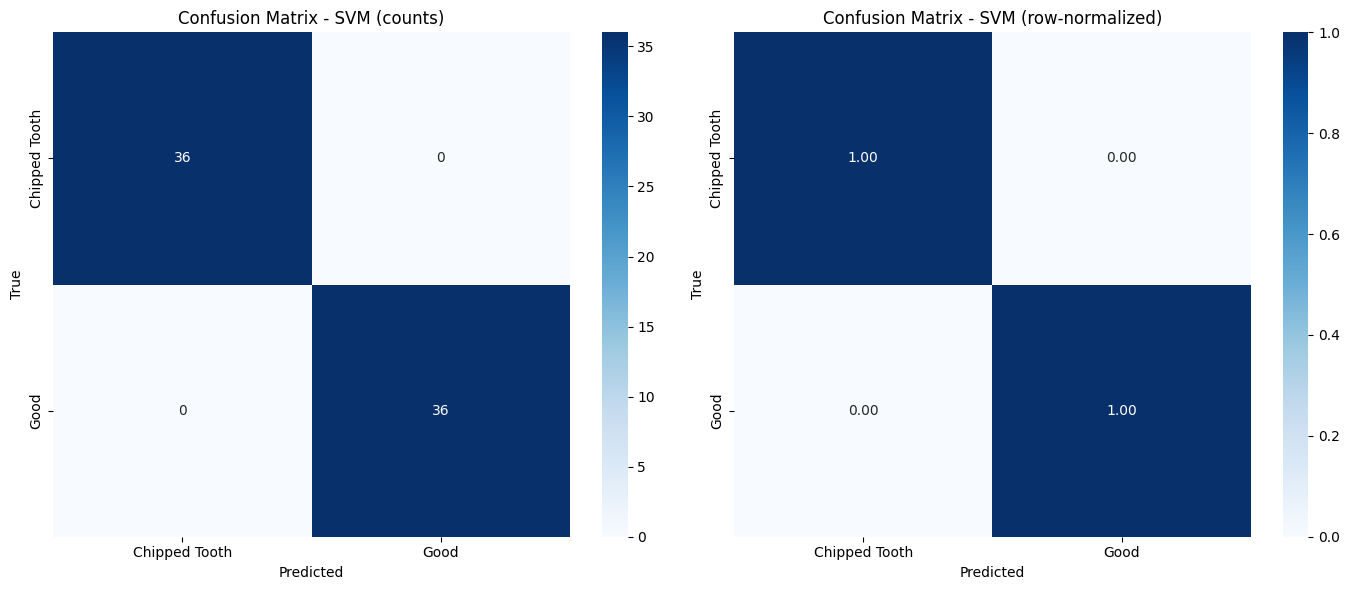

In [57]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix heatmaps for all classes (counts and row-normalized)
# Uses existing variables from the notebook if available: classes_all, y_test, y_pred_best, cm_all, cm_all_norm

import matplotlib.pyplot as plt

# determine class order
labels = sorted(np.unique(np.concatenate([np.asarray(y_test), np.asarray(y_pred_best)])))

# predictions (fallback to best_model if y_pred_best missing)
if 'y_pred_best' in globals() and np.asarray(y_pred_best).shape[0] == np.asarray(y_test).shape[0]:
    y_pred = np.asarray(y_pred_best)
else:
    # try to predict using best_model and X_test_scaled
    try:
        y_pred = best_model.predict(X_test_scaled)
    except Exception:
        raise RuntimeError("y_pred_best missing and best_model/X_test_scaled prediction failed.")

# confusion matrices (counts + row-normalized)
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Safe row normalization (avoid divide-by-zero)
row_sums = cm.sum(axis=1, keepdims=True).astype(float)
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = np.divide(cm, row_sums, where=row_sums != 0)
    cm_norm = np.nan_to_num(cm_norm)

# Plot heatmaps
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
axs[0].set_title(f'Confusion Matrix - {best_name} (counts)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_title(f'Confusion Matrix - {best_name} (row-normalized)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

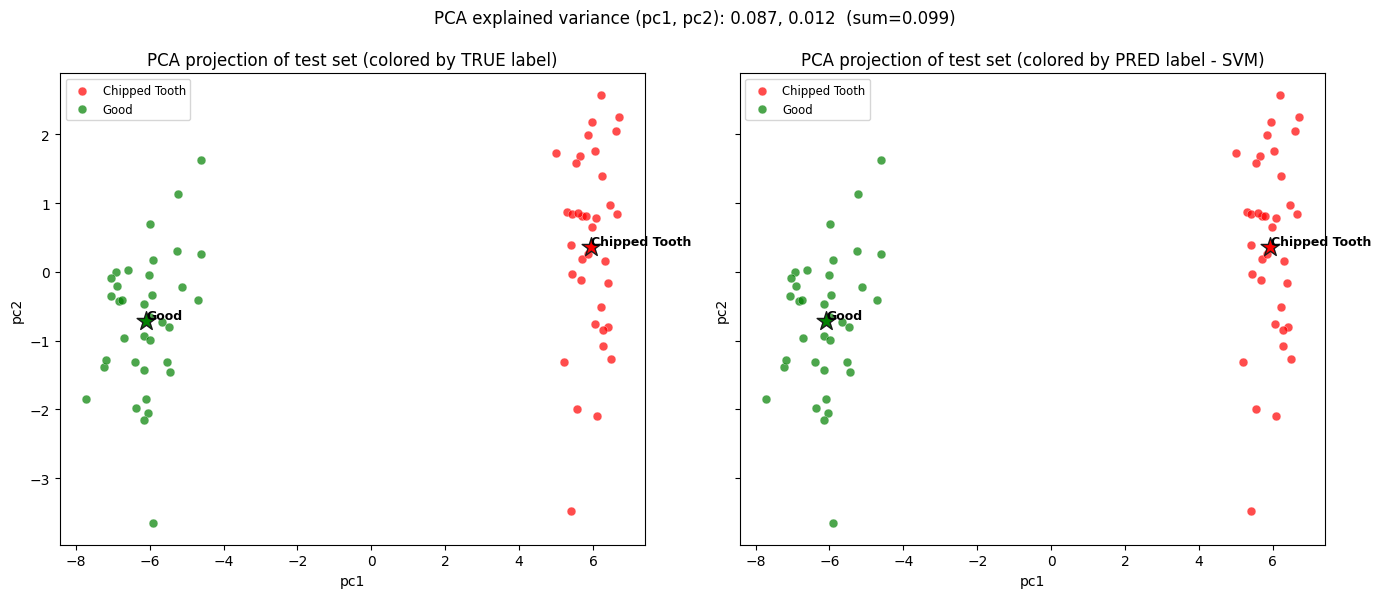

In [58]:
from sklearn.decomposition import PCA as _PCA
import warnings

# PCA-like 2D projection of the test set (unsupervised: PCA fit on train if available, otherwise on test)

# Suppress all warnings during PCA and plotting
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # use existing pca if present, otherwise create one
    pca = _PCA(n_components=2, random_state=42)

    # fit PCA on train (preferred) or on test if train not available
    if 'X_train_scaled' in globals() and getattr(X_train_scaled, "size", 0):
        pca.fit(X_train_scaled)
        proj = pca.transform(X_test_scaled)
    else:
        proj = pca.fit_transform(X_test_scaled)

    # build DataFrame for plotting
    df_proj = pd.DataFrame(proj, columns=['pc1', 'pc2'])
    df_proj['true'] = y_test
    df_proj['pred'] = y_pred_best

    # centroids per true class
    centroids = df_proj.groupby('true')[['pc1', 'pc2']].mean()

    # Create custom color mapping - "Good" is always green
    labels_plot = list(dict.fromkeys(list(best_model.classes_) + list(np.unique(y_test).tolist())))
    color_map = {}
    other_colors = ['red', 'orange', 'purple', 'brown', 'pink', 'cyan', 'magenta']
    other_idx = 0

    for lab in labels_plot:
        if str(lab).lower() in ['good', 'normal', 'healthy']:
            color_map[lab] = 'green'
        else:
            color_map[lab] = other_colors[other_idx % len(other_colors)]
            other_idx += 1

    # plot: left = colored by TRUE, right = colored by PRED (best model)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    for ax, col, title in zip(axs, ['true', 'pred'], ['PCA projection of test set (colored by TRUE label)', f'PCA projection of test set (colored by PRED label - {best_name})']):
        for lab in labels_plot:
            sel = df_proj[col] == lab
            if sel.any():
                ax.scatter(df_proj.loc[sel, 'pc1'], df_proj.loc[sel, 'pc2'], s=40, color=color_map[lab], label=lab, alpha=0.7, edgecolor='w', linewidth=0.3)
        # highlight misclassified points on the PRED plot
        if col == 'pred':
            mis = df_proj['true'] != df_proj['pred']
            if mis.any():
                ax.scatter(df_proj.loc[mis, 'pc1'], df_proj.loc[mis, 'pc2'], facecolors='none', edgecolors='red', s=80, linewidths=1.2, label='misclassified')
        # draw centroids
        for lab, row in centroids.iterrows():
            if lab in color_map:
                ax.scatter(row['pc1'], row['pc2'], marker='*', s=200, color=color_map[lab], edgecolor='k')
                ax.text(row['pc1'] + 0.02, row['pc2'] + 0.02, str(lab), fontsize=9, weight='bold')
        ax.set_title(title)
        ax.set_xlabel('pc1')
        ax.set_ylabel('pc2')
        ax.legend(loc='best', fontsize='small')

    explained = pca.explained_variance_ratio_
    plt.suptitle(f'PCA explained variance (pc1, pc2): {explained[0]:.3f}, {explained[1]:.3f}  (sum={explained[:2].sum():.3f})', y=0.99)
    plt.tight_layout()
    plt.show()

In [59]:
import os
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# Retrain the selected best_model on ALL data (train + test) and save model + scaler for deployment

# Preconditions
if 'best_model' not in globals():
    raise RuntimeError("best_model not found. Run the training cells first.")

# Reconstruct raw (unscaled) feature matrices if needed
if 'X_train_scaled' in globals() and 'X_test_scaled' in globals() and 'scaler' in globals():
    try:
        X_train_raw = scaler.inverse_transform(X_train_scaled) if getattr(X_train_scaled, "size", 0) else np.empty((0, X_train_scaled.shape[1]))
    except Exception:
        X_train_raw = globals().get('X_train', np.empty((0,)))
    try:
        X_test_raw = scaler.inverse_transform(X_test_scaled) if getattr(X_test_scaled, "size", 0) else np.empty((0, X_test_scaled.shape[1]))
    except Exception:
        X_test_raw = globals().get('X_test', np.empty((0,)))
elif 'X_train' in globals() and 'X_test' in globals():
    X_train_raw = globals()['X_train']
    X_test_raw = globals()['X_test']
else:
    raise RuntimeError("Could not locate feature arrays (X_train/X_test or X_train_scaled/X_test_scaled).")

# Labels
if 'y_train' in globals() and 'y_test' in globals():
    y_all = np.concatenate([y_train, y_test])
else:
    raise RuntimeError("y_train/y_test not found. Cannot build labels for retraining.")

# Stack features
if X_train_raw.size == 0 and X_test_raw.size == 0:
    raise RuntimeError("No feature rows found to retrain on.")
X_all_raw = np.vstack([X_train_raw, X_test_raw]) if X_train_raw.size or X_test_raw.size else np.empty((0, X_train_raw.shape[1]))

# Fit new scaler on full data and transform
deploy_scaler = StandardScaler()
X_all_scaled = deploy_scaler.fit_transform(X_all_raw)

# Recreate an unfitted model of the same class/config as best_model and fit on all data
model_cls = best_model.__class__
model_params = best_model.get_params()
deployed_model = model_cls(**model_params)
deployed_model.fit(X_all_scaled, y_all)

# Save deployed model + scaler
#out_dir = Path("models")
#out_dir.mkdir(parents=True, exist_ok=True)
#model_path = out_dir / "deployed_model.pkl"
#scaler_path = out_dir / "deployed_scaler.pkl"
#joblib.dump(deployed_model, model_path)
#joblib.dump(deploy_scaler, scaler_path)

# Expose for later cells
#deployed = deployed_model
#deployed_scaler = deploy_scaler
#deployed_artifacts = {"model_path": str(model_path), "scaler_path": str(scaler_path)}

print(f"Deployed model trained on all data: {X_all_scaled.shape[0]} samples, {X_all_scaled.shape[1]} features")
#print(f"Saved model -> {model_path}")
#print(f"Saved scaler -> {scaler_path}")

Deployed model trained on all data: 644 samples, 443 features


## 6) Batch prediction on new sample set

We will now run the best-performing model from this notebook on a separate set of unlabeled (or validation) samples located under `sample_data/audio/`.

Folder structure is expected as:
```
sample_data/audio/<label_name>/*.wav
```
Each folder name will be treated as the ground-truth class for evaluation. We will:
1. Discover all audio files.
2. Load + resample them with the shared loader (fixed 40 kHz).
3. Segment and extract features using the same parameters (`segment_seconds`, `overlap`, `feature_level`).
4. Predict per-segment and aggregate to a file-level prediction (mean probability or majority vote).
5. Produce a results DataFrame and overall accuracy (if labels are available via folder names).
6. Show a confusion matrix.


In [61]:
# Batch prediction UI using external helper script (isolated import of batch_predict only)
from pathlib import Path
import importlib.util

# Dynamically load batch_predict WITHOUT adding the whole Models directory to sys.path
_bp_path = Path('Preparation/Sample Preparation/Models/batch_predict.py').resolve()
if not _bp_path.exists():
    raise FileNotFoundError(f'Cannot locate batch_predict.py at {_bp_path}')
_spec = importlib.util.spec_from_file_location('batch_predict_ui', str(_bp_path))
_bp_mod = importlib.util.module_from_spec(_spec)
_spec.loader.exec_module(_bp_mod)  # type: ignore[attr-defined]
render_batch_prediction_ui = getattr(_bp_mod, 'render_batch_prediction_ui')

# Reuse variables from notebook; ensure best_model & scaler exist
if 'best_model' not in globals() or 'scaler' not in globals():
    raise RuntimeError('Train models first so best_model and scaler are defined.')


# Only the in-notebook trained best_model is used for inference below.
ui_batch = render_batch_prediction_ui(
    best_model=deployed_model,
    scaler=scaler,
    segment_seconds=segment_seconds,
    overlap=overlap,
    feature_level=feature_level,
    train_feat_names=feat_names if 'feat_names' in globals() else None,
    sample_root=Path('sample_data/audio'),
)
ui_batch

## 7) Live Audio Inspection - Continuous Monitoring

This section demonstrates deploying the trained model for real-time continuous inspection. In industrial scenarios, this would be used to monitor machinery continuously and alert operators to potential faults as they develop.

We'll implement two approaches:
1. **Real-time live audio capture** - Stream audio from a microphone/sensor in real-time
2. **File-based simulation** - Simulate streaming by reading from an existing audio file

This simulates how the trained model would be deployed in production for continuous predictive maintenance monitoring.

In [62]:
# Import the live inspection module
from pathlib import Path
import importlib.util
import numpy as np
import pandas as pd
import time

# Dynamically load live_inspector module
_li_path = Path('Preparation/Sample Preparation/Models/live_inspector.py').resolve()
if not _li_path.exists():
    raise FileNotFoundError(f'Cannot locate live_inspector.py at {_li_path}')
    
_spec = importlib.util.spec_from_file_location('live_inspector', str(_li_path))
_li_mod = importlib.util.module_from_spec(_spec)
_spec.loader.exec_module(_li_mod)

# Import classes and functions
LiveAudioInspector = _li_mod.LiveAudioInspector
create_live_inspector_ui = _li_mod.create_live_inspector_ui
simulate_streaming_from_file = _li_mod.simulate_streaming_from_file

print("Live inspection module loaded successfully!")

Live inspection module loaded successfully!


In [63]:
# Configure the live inspector with our trained model
# Ensure we have the required variables from training
if 'best_model' not in globals() or 'scaler' not in globals():
    raise RuntimeError('Please run the training section first to create best_model and scaler')

# Create live inspector instance
inspector = LiveAudioInspector(
    model=deployed_model,
    scaler=scaler,
    segment_seconds=segment_seconds,  # Analyze 2-second segments
    overlap=overlap,          # 50% overlap between segments
    feature_level=feature_level,  # Use same feature level as training
    feature_names=feat_names,     # Expected feature names from training
    buffer_duration=10.0,         # Keep 10 seconds of audio in buffer
    device=1                   # Use default microphone (change if needed)
)

print(f"Live inspector configured:")
print(f"  Model: {best_name}")
print(f"  Feature level: {feature_level}")
print(f"  Segment duration: {segment_seconds}s with {overlap*100}% overlap")
print(f"  Expected features: {len(feat_names) if feat_names else 'Unknown'}")
print(f"  Model classes: {list(deployed_model.classes_)}")
print("\\nReady for live inspection!")

Live inspector configured:
  Model: SVM
  Feature level: standard
  Segment duration: 5s with 50.0% overlap
  Expected features: 443
  Model classes: [np.str_('Chipped Tooth'), np.str_('Good')]
\nReady for live inspection!


### Option 1: Real-Time Live Audio Capture

This creates an interactive UI for real-time audio monitoring. When you click "Start Inspection", the system will:

1. Start capturing audio from your microphone/audio interface
2. Continuously analyze 2-second segments with 50% overlap  
3. Extract the same features used during training
4. Make predictions using the trained model
5. Display results in real-time with confidence scores
6. Plot prediction timeline and confidence trends

**Note:** Make sure your audio device is connected and accessible before starting.

In [64]:
# List available audio devices first
import sounddevice as sd

print("Available audio input devices:")
devices = sd.query_devices()
for i, device in enumerate(devices):
    if device['max_input_channels'] > 0:
        print(f"  {i}: {device['name']} ({device['max_input_channels']} ch, {device['default_samplerate']} Hz)")

print(f"\\nDefault input device: {sd.default.device[0] if hasattr(sd.default, 'device') else 'None'}")
print("\\nTo use a specific device, modify the 'device' parameter when creating the inspector.")

Available audio input devices:
  0: Ibrahim’s iPhone Microphone (1 ch, 48000.0 Hz)
  1: MacBook Pro Microphone (1 ch, 44100.0 Hz)
  3: Ibrahim’s AirPods Pro (1 ch, 24000.0 Hz)
  5: Immersed (2 ch, 48000.0 Hz)
\nDefault input device: 3
\nTo use a specific device, modify the 'device' parameter when creating the inspector.


In [65]:
# Create and display the enhanced live inspection UI with industrial design
import importlib
import sys

# Force reload to get the latest enhanced version
if 'live_inspector' in sys.modules:
    importlib.reload(sys.modules['live_inspector'])

# Re-import the updated module
LiveAudioInspector = _li_mod.LiveAudioInspector
create_live_inspector_ui = _li_mod.create_live_inspector_ui

# Create the enhanced industrial-grade live inspector UI
live_ui = create_live_inspector_ui(inspector)
display(live_ui)

# Enhanced instructions for the new system
print("\\n" + "="*80)
print("🏭 INDUSTRIAL PREDICTIVE MAINTENANCE MONITORING SYSTEM")
print("="*80)
print("🚀 SYSTEM FEATURES:")
print("  • Advanced threshold-based confidence monitoring")
print("  • Real-time alert system for low confidence predictions") 
print("  • Industrial-grade UI with professional status indicators")
print("  • Enhanced plotting with threshold zones and trend analysis")
print("  • Comprehensive metrics tracking and session statistics")
print("  • Emergency stop functionality for safety compliance")
print("")
print("🎯 THRESHOLD MONITORING:")
print("  • Set confidence threshold using the precision slider")
print("  • Green zone (≥ threshold): Normal operation")
print("  • Red zone (< threshold): Alert condition with warnings")
print("  • Automatic alerts: 'Low confidence prediction - check hardware or model'")
print("  • Threshold line displayed on all monitoring plots")
print("")
print("📊 ENHANCED VISUALIZATIONS:")
print("  • Dual-zone plotting with safety threshold indicators")
print("  • Real-time confidence trend analysis with moving averages")
print("  • Color-coded prediction status (Normal/Alert)")
print("  • Advanced annotations with system status information")
print("")
print("🔧 OPERATION GUIDE:")
print("  1. Configure confidence threshold (recommended: 0.70)")
print("  2. Click 'START MONITORING' to begin industrial-grade analysis")
print("  3. Monitor dashboard for real-time predictions and alerts")
print("  4. Watch threshold compliance indicators on plots")
print("  5. Respond to low confidence alerts as they appear")
print("  6. Use 'EMERGENCY STOP' for immediate system shutdown")
print("")
print("⚡ TROUBLESHOOTING:")
print("  • System provides detailed error diagnostics")
print("  • Audio device issues are clearly identified")
print("  • File-based simulation available for testing")
print("  • Session metrics help identify performance patterns")
print("="*80)

\n================================================================================
🏭 INDUSTRIAL PREDICTIVE MAINTENANCE MONITORING SYSTEM
🚀 SYSTEM FEATURES:
  • Advanced threshold-based confidence monitoring
  • Real-time alert system for low confidence predictions
  • Industrial-grade UI with professional status indicators
  • Enhanced plotting with threshold zones and trend analysis
  • Comprehensive metrics tracking and session statistics
  • Emergency stop functionality for safety compliance

🎯 THRESHOLD MONITORING:
  • Set confidence threshold using the precision slider
  • Green zone (≥ threshold): Normal operation
  • Red zone (< threshold): Alert condition with warnings
  • Automatic alerts: 'Low confidence prediction - check hardware or model'
  • Threshold line displayed on all monitoring plots

📊 ENHANCED VISUALIZATIONS:
  • Dual-zone plotting with safety threshold indicators
  • Real-time confidence trend analysis with moving averages
  • Color-coded prediction status (Norma

### 🎯 Advanced Threshold Monitoring Features

The enhanced system now includes industrial-grade threshold monitoring capabilities:

**🔍 Key Features:**
- **Precision Threshold Control**: Set exact confidence thresholds with 0.001 precision
- **Real-Time Alert System**: Automatic warnings when predictions fall below threshold
- **Visual Threshold Indicators**: Red dashed lines on all plots show threshold boundaries
- **Safety Zones**: Green (safe) and red (alert) zones clearly marked on visualizations
- **Alert Message**: "Low confidence prediction - please check hardware or model"

**🏭 Industrial Design Elements:**
- Professional gradient headers with industrial color schemes
- LED-style status indicators (🟢 Online, 🔴 Offline, 🚨 Emergency)
- Metrics dashboard with uptime, prediction counts, and alert statistics
- Emergency stop functionality for safety-critical applications
- Enhanced error handling with detailed troubleshooting guidance

**📊 Advanced Visualizations:**
- Dual-plot dashboard with threshold zones
- Moving average trend analysis for confidence monitoring
- Color-coded prediction markers (normal vs. alert conditions)
- Real-time annotations with latest system status
- Professional styling matching state-of-the-art monitoring systems

This system is designed to meet industrial standards for machine monitoring and predictive maintenance applications.

In [49]:
# Demo: Testing different threshold scenarios for industrial applications
print("🎯 THRESHOLD CONFIGURATION RECOMMENDATIONS")
print("="*50)
print()

# Different threshold scenarios for various industrial applications
threshold_scenarios = {
    "High-Critical Systems": {
        "threshold": 0.90,
        "description": "Nuclear, aerospace, medical devices",
        "alert_frequency": "Very High",
        "use_case": "Zero-tolerance for false predictions"
    },
    "Standard Manufacturing": {
        "threshold": 0.75,
        "description": "General production lines, quality control",
        "alert_frequency": "Moderate",
        "use_case": "Balance between sensitivity and false alarms"
    },
    "Early Warning Systems": {
        "threshold": 0.60,
        "description": "Predictive maintenance, trend monitoring",
        "alert_frequency": "High",  
        "use_case": "Catch potential issues early"
    },
    "Research & Development": {
        "threshold": 0.50,
        "description": "Model testing, data exploration",
        "alert_frequency": "Very High",
        "use_case": "Maximum sensitivity for analysis"
    }
}

for scenario, config in threshold_scenarios.items():
    print(f"📊 {scenario}:")
    print(f"   Threshold: {config['threshold']:.2f}")
    print(f"   Application: {config['description']}")
    print(f"   Alert Level: {config['alert_frequency']}")
    print(f"   Use Case: {config['use_case']}")
    print()

print("💡 THRESHOLD TUNING TIPS:")
print("• Higher thresholds = More conservative, fewer false alarms")
print("• Lower thresholds = More sensitive, early warning capability")
print("• Monitor alert frequency and adjust based on operational needs")
print("• Consider cost of false positives vs. missed detections")
print()
print("🔧 The system above allows real-time threshold adjustment")
print("   to find the optimal balance for your specific application!")

🎯 THRESHOLD CONFIGURATION RECOMMENDATIONS

📊 High-Critical Systems:
   Threshold: 0.90
   Application: Nuclear, aerospace, medical devices
   Alert Level: Very High
   Use Case: Zero-tolerance for false predictions

📊 Standard Manufacturing:
   Threshold: 0.75
   Application: General production lines, quality control
   Alert Level: Moderate
   Use Case: Balance between sensitivity and false alarms

📊 Early Warning Systems:
   Threshold: 0.60
   Application: Predictive maintenance, trend monitoring
   Alert Level: High
   Use Case: Catch potential issues early

📊 Research & Development:
   Threshold: 0.50
   Application: Model testing, data exploration
   Alert Level: Very High
   Use Case: Maximum sensitivity for analysis

💡 THRESHOLD TUNING TIPS:
• Higher thresholds = More conservative, fewer false alarms
• Lower thresholds = More sensitive, early warning capability
• Monitor alert frequency and adjust based on operational needs
• Consider cost of false positives vs. missed detection

### Production Deployment Considerations

The live inspection system demonstrated above provides a foundation for real-world predictive maintenance deployment. For production use, consider these enhancements:

**Alerting System:**
- Set up automatic alerts for fault detection
- Implement email/SMS notifications for predictions
- Create escalation procedures for critical predictions

**Data Logging:**
- Store all predictions with timestamps in a database
- Log raw audio segments for later analysis
- Track model performance over time

**Model Management:**
- Implement A/B testing for model updates
- Monitor for model performance over time
- Set up automated retraining pipelines

**Scalability:**
- Deploy using containerization (Docker/Kubernetes)
- Implement load balancing for multiple sensors
- Use message queues for high-throughput scenarios

**Integration:**
- Connect to existing SCADA/MES systems
- Provide REST APIs for external applications
- Export data to maintenance management systems

The code structure provided here can be extended to implement these production features while maintaining the core prediction functionality demonstrated in this workshop.